# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

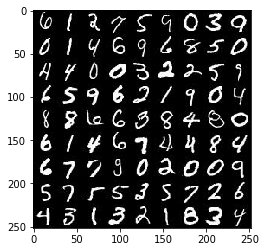

In [2]:
show_n_images = 81

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

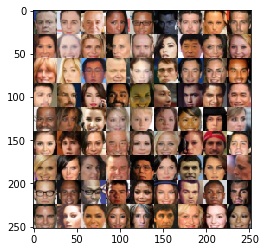

In [3]:
show_n_images = 81

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:

def  discriminator (images, reuse=False, alpha=0.2, dropout=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h1 = tf.layers.dropout(inputs=h1, rate=dropout, training=False)   
        h1 = tf.layers.batch_normalization(h1, training=True)
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h2 = tf.layers.dropout(inputs=h2, rate=dropout, training=False)      
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 
                              strides=2, 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer(),
                              activation=tf.nn.relu)
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        #h4 = tf.layers.conv2d(h3, 512, 5, strides=2, padding='same',
        #                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
        #                      activation=tf.nn.relu)
        #h4 = tf.layers.dropout(inputs=h4, rate=dropout, training=False)
        #h4 = tf.layers.batch_normalization(h4, training=True)
        #h4 = tf.maximum(alpha * h4, h4)
        
        #flat = tf.reshape(h4, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(h3)

        #dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, dropout=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512

        h2 = tf.layers.conv2d_transpose(h1, 256, 
                                        kernel_size=4, 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h2 = tf.layers.dropout(inputs=h2, rate=dropout, training=is_train)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, 
                                        kernel_size=4, 
                                        strides=2, 
                                        padding='valid',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        h3 = tf.layers.dropout(inputs=h3, rate=dropout, training=is_train)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        # 28x28x5
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, dropout=0.8, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.75
    images_to_show = 9
    losses =[]
    step = 0

    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha=leaky_alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting the training")    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    
    print("Finished the training")                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting the training
Step: 10: Epoch 1/2... Discriminator Loss: 0.3549... Generator Loss: 4.4835
Step: 20: Epoch 1/2... Discriminator Loss: 0.4076... Generator Loss: 4.1332
Step: 30: Epoch 1/2... Discriminator Loss: 0.3570... Generator Loss: 5.1278
Step: 40: Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 2.4702
Step: 50: Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 4.4984
Step: 60: Epoch 1/2... Discriminator Loss: 0.5321... Generator Loss: 3.2804
Step: 70: Epoch 1/2... Discriminator Loss: 0.3864... Generator Loss: 5.2063
Step: 80: Epoch 1/2... Discriminator Loss: 0.4271... Generator Loss: 5.8227
Step: 90: Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.8349
Step: 100: Epoch 1/2... Discriminator Loss: 0.3382... Generator Loss: 5.5504


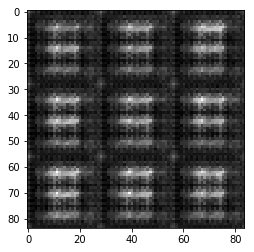

Step: 110: Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 5.2007
Step: 120: Epoch 1/2... Discriminator Loss: 0.3477... Generator Loss: 5.5844
Step: 130: Epoch 1/2... Discriminator Loss: 0.3776... Generator Loss: 5.1135
Step: 140: Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 5.8961
Step: 150: Epoch 1/2... Discriminator Loss: 0.3815... Generator Loss: 4.7891
Step: 160: Epoch 1/2... Discriminator Loss: 0.3611... Generator Loss: 4.7123
Step: 170: Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 9.1764
Step: 180: Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 4.5635
Step: 190: Epoch 1/2... Discriminator Loss: 0.3746... Generator Loss: 4.5233
Step: 200: Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 5.6493


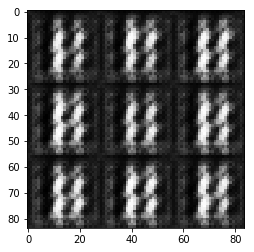

Step: 210: Epoch 1/2... Discriminator Loss: 0.3518... Generator Loss: 5.3838
Step: 220: Epoch 1/2... Discriminator Loss: 0.3637... Generator Loss: 4.0415
Step: 230: Epoch 1/2... Discriminator Loss: 0.3562... Generator Loss: 5.0414
Step: 240: Epoch 1/2... Discriminator Loss: 0.3513... Generator Loss: 5.1659
Step: 250: Epoch 1/2... Discriminator Loss: 0.3441... Generator Loss: 5.3251
Step: 260: Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 4.4851
Step: 270: Epoch 1/2... Discriminator Loss: 0.3704... Generator Loss: 4.1826
Step: 280: Epoch 1/2... Discriminator Loss: 0.3851... Generator Loss: 4.0388
Step: 290: Epoch 1/2... Discriminator Loss: 0.3409... Generator Loss: 4.9782
Step: 300: Epoch 1/2... Discriminator Loss: 0.3397... Generator Loss: 5.8531


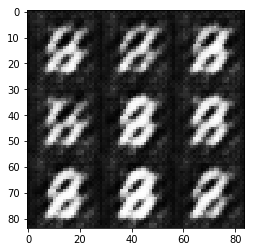

Step: 310: Epoch 1/2... Discriminator Loss: 0.4033... Generator Loss: 4.4829
Step: 320: Epoch 1/2... Discriminator Loss: 0.3958... Generator Loss: 5.0115
Step: 330: Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 7.8441
Step: 340: Epoch 1/2... Discriminator Loss: 0.3440... Generator Loss: 5.0680
Step: 350: Epoch 1/2... Discriminator Loss: 2.3292... Generator Loss: 0.2374
Step: 360: Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 4.5655
Step: 370: Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 4.4062
Step: 380: Epoch 1/2... Discriminator Loss: 0.4992... Generator Loss: 3.4119
Step: 390: Epoch 1/2... Discriminator Loss: 0.3600... Generator Loss: 4.2699
Step: 400: Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 3.9090


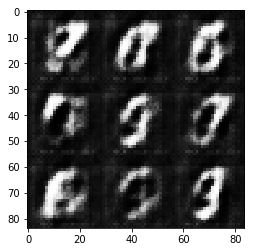

Step: 410: Epoch 1/2... Discriminator Loss: 0.3698... Generator Loss: 4.4989
Step: 420: Epoch 1/2... Discriminator Loss: 0.3495... Generator Loss: 5.0485
Step: 430: Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 4.9426
Step: 440: Epoch 1/2... Discriminator Loss: 0.3646... Generator Loss: 3.9076
Step: 450: Epoch 1/2... Discriminator Loss: 0.3568... Generator Loss: 5.6608
Step: 460: Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 4.9077
Step: 470: Epoch 1/2... Discriminator Loss: 0.3854... Generator Loss: 4.7895
Step: 480: Epoch 1/2... Discriminator Loss: 0.3748... Generator Loss: 4.7722
Step: 490: Epoch 1/2... Discriminator Loss: 0.3668... Generator Loss: 4.4173
Step: 500: Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 5.4142


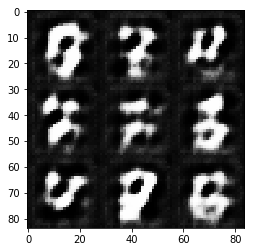

Step: 510: Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 5.8637
Step: 520: Epoch 1/2... Discriminator Loss: 0.3391... Generator Loss: 5.4651
Step: 530: Epoch 1/2... Discriminator Loss: 0.4245... Generator Loss: 3.4667
Step: 540: Epoch 1/2... Discriminator Loss: 0.3423... Generator Loss: 5.2216
Step: 550: Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 2.7436
Step: 560: Epoch 1/2... Discriminator Loss: 0.3749... Generator Loss: 5.6403
Step: 570: Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 4.8691
Step: 580: Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 5.0120
Step: 590: Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 3.3694
Step: 600: Epoch 1/2... Discriminator Loss: 0.3750... Generator Loss: 5.5367


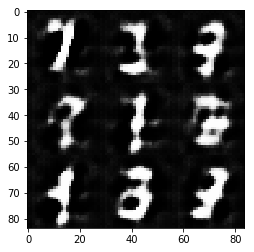

Step: 610: Epoch 1/2... Discriminator Loss: 0.3802... Generator Loss: 4.0684
Step: 620: Epoch 1/2... Discriminator Loss: 1.2174... Generator Loss: 1.3389
Step: 630: Epoch 1/2... Discriminator Loss: 0.3855... Generator Loss: 4.4839
Step: 640: Epoch 1/2... Discriminator Loss: 0.3504... Generator Loss: 4.4139
Step: 650: Epoch 1/2... Discriminator Loss: 0.4128... Generator Loss: 4.1449
Step: 660: Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 4.8041
Step: 670: Epoch 1/2... Discriminator Loss: 0.3466... Generator Loss: 5.7057
Step: 680: Epoch 1/2... Discriminator Loss: 0.3518... Generator Loss: 5.1706
Step: 690: Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 5.8492
Step: 700: Epoch 1/2... Discriminator Loss: 0.3455... Generator Loss: 5.8331


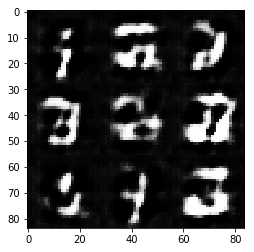

Step: 710: Epoch 1/2... Discriminator Loss: 0.3395... Generator Loss: 5.5381
Step: 720: Epoch 1/2... Discriminator Loss: 0.3433... Generator Loss: 5.7388
Step: 730: Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 5.2101
Step: 740: Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 5.3138
Step: 750: Epoch 1/2... Discriminator Loss: 0.4329... Generator Loss: 3.5649
Step: 760: Epoch 1/2... Discriminator Loss: 0.3521... Generator Loss: 6.1129
Step: 770: Epoch 1/2... Discriminator Loss: 0.4084... Generator Loss: 3.3157
Step: 780: Epoch 1/2... Discriminator Loss: 0.3604... Generator Loss: 6.3801
Step: 790: Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 5.5193
Step: 800: Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 5.7607


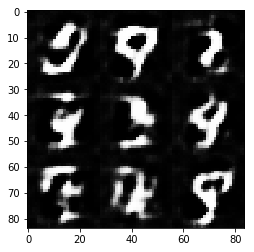

Step: 810: Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 5.0785
Step: 820: Epoch 1/2... Discriminator Loss: 0.3407... Generator Loss: 5.2261
Step: 830: Epoch 1/2... Discriminator Loss: 0.5147... Generator Loss: 2.7333
Step: 840: Epoch 1/2... Discriminator Loss: 0.3597... Generator Loss: 4.4436
Step: 850: Epoch 1/2... Discriminator Loss: 0.3356... Generator Loss: 5.1115
Step: 860: Epoch 1/2... Discriminator Loss: 0.3432... Generator Loss: 5.8878
Step: 870: Epoch 1/2... Discriminator Loss: 0.3578... Generator Loss: 4.3832
Step: 880: Epoch 1/2... Discriminator Loss: 0.3837... Generator Loss: 4.3963
Step: 890: Epoch 1/2... Discriminator Loss: 0.4031... Generator Loss: 3.9729
Step: 900: Epoch 1/2... Discriminator Loss: 2.6627... Generator Loss: 11.1903


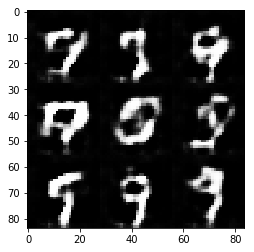

Step: 910: Epoch 1/2... Discriminator Loss: 0.3803... Generator Loss: 4.0864
Step: 920: Epoch 1/2... Discriminator Loss: 0.3486... Generator Loss: 4.9474
Step: 930: Epoch 1/2... Discriminator Loss: 0.3762... Generator Loss: 4.3462
Step: 940: Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 4.5992
Step: 950: Epoch 1/2... Discriminator Loss: 0.3490... Generator Loss: 5.0959
Step: 960: Epoch 1/2... Discriminator Loss: 0.3456... Generator Loss: 5.1244
Step: 970: Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 5.7266
Step: 980: Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 5.5858
Step: 990: Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 5.0499
Step: 1000: Epoch 1/2... Discriminator Loss: 0.4502... Generator Loss: 2.7215


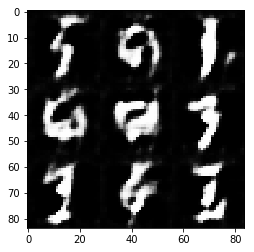

Step: 1010: Epoch 1/2... Discriminator Loss: 0.3436... Generator Loss: 5.3057
Step: 1020: Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 6.2129
Step: 1030: Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 5.2008
Step: 1040: Epoch 1/2... Discriminator Loss: 0.4536... Generator Loss: 3.8307
Step: 1050: Epoch 1/2... Discriminator Loss: 0.3451... Generator Loss: 5.8275
Step: 1060: Epoch 1/2... Discriminator Loss: 0.3384... Generator Loss: 7.8323
Step: 1070: Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 5.9319
Step: 1080: Epoch 1/2... Discriminator Loss: 0.3406... Generator Loss: 4.1961
Step: 1090: Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 4.6557
Step: 1100: Epoch 1/2... Discriminator Loss: 0.3437... Generator Loss: 5.3217


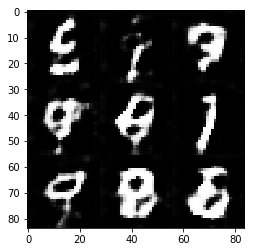

Step: 1110: Epoch 1/2... Discriminator Loss: 0.3937... Generator Loss: 4.6322
Step: 1120: Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 5.4570
Step: 1130: Epoch 1/2... Discriminator Loss: 0.3589... Generator Loss: 3.9999
Step: 1140: Epoch 1/2... Discriminator Loss: 0.4166... Generator Loss: 4.1836
Step: 1150: Epoch 1/2... Discriminator Loss: 0.3399... Generator Loss: 4.6073
Step: 1160: Epoch 1/2... Discriminator Loss: 0.3446... Generator Loss: 5.3385
Step: 1170: Epoch 1/2... Discriminator Loss: 0.3525... Generator Loss: 5.3537
Step: 1180: Epoch 1/2... Discriminator Loss: 0.3494... Generator Loss: 5.0086
Step: 1190: Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 4.6561
Step: 1200: Epoch 1/2... Discriminator Loss: 0.3385... Generator Loss: 6.2951


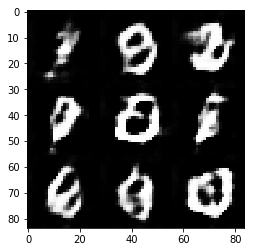

Step: 1210: Epoch 1/2... Discriminator Loss: 0.3700... Generator Loss: 5.7664
Step: 1220: Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 5.5368
Step: 1230: Epoch 1/2... Discriminator Loss: 0.3449... Generator Loss: 6.7050
Step: 1240: Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 3.2054
Step: 1250: Epoch 1/2... Discriminator Loss: 0.3662... Generator Loss: 4.4372
Step: 1260: Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 2.8350
Step: 1270: Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 5.1611
Step: 1280: Epoch 1/2... Discriminator Loss: 0.5846... Generator Loss: 3.8025
Step: 1290: Epoch 1/2... Discriminator Loss: 0.3516... Generator Loss: 5.1355
Step: 1300: Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 4.6868


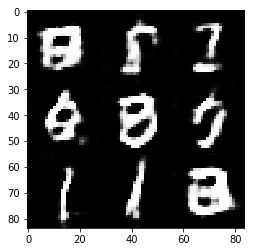

Step: 1310: Epoch 1/2... Discriminator Loss: 0.3684... Generator Loss: 4.7554
Step: 1320: Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 5.8172
Step: 1330: Epoch 1/2... Discriminator Loss: 0.3444... Generator Loss: 4.9303
Step: 1340: Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 5.5145
Step: 1350: Epoch 1/2... Discriminator Loss: 0.3362... Generator Loss: 5.9072
Step: 1360: Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 4.9837
Step: 1370: Epoch 1/2... Discriminator Loss: 0.3714... Generator Loss: 5.0639
Step: 1380: Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 5.2067
Step: 1390: Epoch 1/2... Discriminator Loss: 0.3386... Generator Loss: 6.1038
Step: 1400: Epoch 1/2... Discriminator Loss: 0.3408... Generator Loss: 5.6397


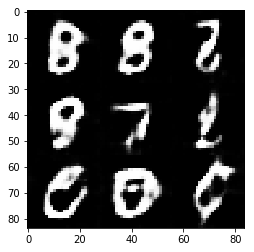

Step: 1410: Epoch 1/2... Discriminator Loss: 0.3419... Generator Loss: 5.2701
Step: 1420: Epoch 1/2... Discriminator Loss: 0.4011... Generator Loss: 4.8925
Step: 1430: Epoch 1/2... Discriminator Loss: 0.3351... Generator Loss: 5.8132
Step: 1440: Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 6.2510
Step: 1450: Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 7.5917
Step: 1460: Epoch 1/2... Discriminator Loss: 0.4402... Generator Loss: 3.2562
Step: 1470: Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 4.3617
Step: 1480: Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 4.7707
Step: 1490: Epoch 1/2... Discriminator Loss: 0.3618... Generator Loss: 4.6358
Step: 1500: Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 4.2109


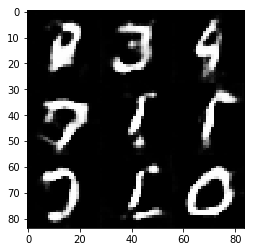

Step: 1510: Epoch 1/2... Discriminator Loss: 0.3914... Generator Loss: 3.9908
Step: 1520: Epoch 1/2... Discriminator Loss: 0.3418... Generator Loss: 7.4116
Step: 1530: Epoch 1/2... Discriminator Loss: 0.3331... Generator Loss: 4.2732
Step: 1540: Epoch 1/2... Discriminator Loss: 0.3358... Generator Loss: 6.2077
Step: 1550: Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 6.5129
Step: 1560: Epoch 1/2... Discriminator Loss: 0.3402... Generator Loss: 6.0299
Step: 1570: Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 4.4556
Step: 1580: Epoch 1/2... Discriminator Loss: 0.3315... Generator Loss: 6.8602
Step: 1590: Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 4.0961
Step: 1600: Epoch 1/2... Discriminator Loss: 0.3441... Generator Loss: 5.3000


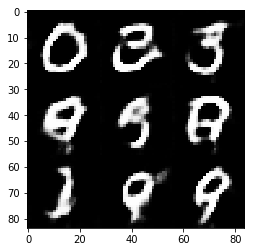

Step: 1610: Epoch 1/2... Discriminator Loss: 0.3393... Generator Loss: 4.4128
Step: 1620: Epoch 1/2... Discriminator Loss: 0.3496... Generator Loss: 6.3081
Step: 1630: Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 5.0860
Step: 1640: Epoch 1/2... Discriminator Loss: 0.3323... Generator Loss: 7.3468
Step: 1650: Epoch 1/2... Discriminator Loss: 0.3381... Generator Loss: 5.6109
Step: 1660: Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 7.4450
Step: 1670: Epoch 1/2... Discriminator Loss: 0.3546... Generator Loss: 5.8162
Step: 1680: Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 2.9477
Step: 1690: Epoch 1/2... Discriminator Loss: 0.3720... Generator Loss: 5.7105
Step: 1700: Epoch 1/2... Discriminator Loss: 0.3429... Generator Loss: 5.9913


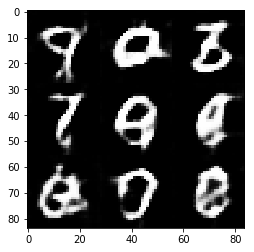

Step: 1710: Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 5.4645
Step: 1720: Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 4.1780
Step: 1730: Epoch 1/2... Discriminator Loss: 0.3376... Generator Loss: 5.8588
Step: 1740: Epoch 1/2... Discriminator Loss: 0.3453... Generator Loss: 6.7822
Step: 1750: Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 2.8786
Step: 1760: Epoch 1/2... Discriminator Loss: 0.3422... Generator Loss: 5.4724
Step: 1770: Epoch 1/2... Discriminator Loss: 0.3747... Generator Loss: 4.7774
Step: 1780: Epoch 1/2... Discriminator Loss: 0.3355... Generator Loss: 5.5688
Step: 1790: Epoch 1/2... Discriminator Loss: 0.3576... Generator Loss: 5.6230
Step: 1800: Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 4.4968


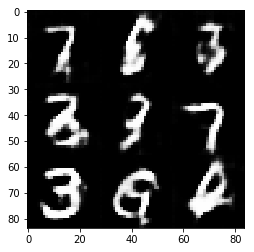

Step: 1810: Epoch 1/2... Discriminator Loss: 0.4692... Generator Loss: 3.2486
Step: 1820: Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 4.2553
Step: 1830: Epoch 1/2... Discriminator Loss: 0.3339... Generator Loss: 5.3407
Step: 1840: Epoch 1/2... Discriminator Loss: 0.3365... Generator Loss: 5.2827
Step: 1850: Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 6.6462
Step: 1860: Epoch 1/2... Discriminator Loss: 0.3422... Generator Loss: 4.7834
Step: 1870: Epoch 1/2... Discriminator Loss: 0.3324... Generator Loss: 6.2766
Step: 1880: Epoch 2/2... Discriminator Loss: 0.3476... Generator Loss: 5.6415
Step: 1890: Epoch 2/2... Discriminator Loss: 0.3437... Generator Loss: 5.2869
Step: 1900: Epoch 2/2... Discriminator Loss: 0.3760... Generator Loss: 3.7448


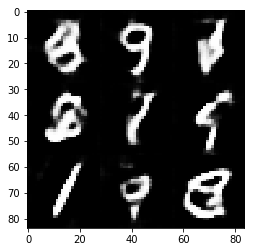

Step: 1910: Epoch 2/2... Discriminator Loss: 0.3710... Generator Loss: 7.0234
Step: 1920: Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 6.6415
Step: 1930: Epoch 2/2... Discriminator Loss: 0.4092... Generator Loss: 3.4585
Step: 1940: Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 5.0677
Step: 1950: Epoch 2/2... Discriminator Loss: 0.3855... Generator Loss: 4.0492
Step: 1960: Epoch 2/2... Discriminator Loss: 0.3403... Generator Loss: 5.7653
Step: 1970: Epoch 2/2... Discriminator Loss: 0.3377... Generator Loss: 5.4597
Step: 1980: Epoch 2/2... Discriminator Loss: 0.3490... Generator Loss: 5.9118
Step: 1990: Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 4.1728
Step: 2000: Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 6.7597


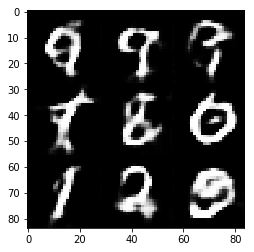

Step: 2010: Epoch 2/2... Discriminator Loss: 0.3541... Generator Loss: 6.7627
Step: 2020: Epoch 2/2... Discriminator Loss: 0.3369... Generator Loss: 5.2739
Step: 2030: Epoch 2/2... Discriminator Loss: 0.3438... Generator Loss: 5.6358
Step: 2040: Epoch 2/2... Discriminator Loss: 0.3481... Generator Loss: 6.6867
Step: 2050: Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 6.1483
Step: 2060: Epoch 2/2... Discriminator Loss: 0.3417... Generator Loss: 5.1069
Step: 2070: Epoch 2/2... Discriminator Loss: 0.3470... Generator Loss: 5.3096
Step: 2080: Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 4.6256
Step: 2090: Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 6.1531
Step: 2100: Epoch 2/2... Discriminator Loss: 0.4624... Generator Loss: 5.4310


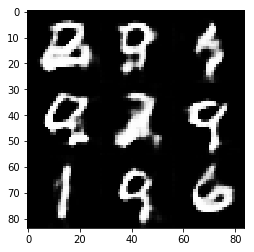

Step: 2110: Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 5.1368
Step: 2120: Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 6.7881
Step: 2130: Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 5.1449
Step: 2140: Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 6.4515
Step: 2150: Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 6.2038
Step: 2160: Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 4.9755
Step: 2170: Epoch 2/2... Discriminator Loss: 0.3407... Generator Loss: 5.4968
Step: 2180: Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 6.2324
Step: 2190: Epoch 2/2... Discriminator Loss: 0.3322... Generator Loss: 4.8352
Step: 2200: Epoch 2/2... Discriminator Loss: 0.3440... Generator Loss: 5.1132


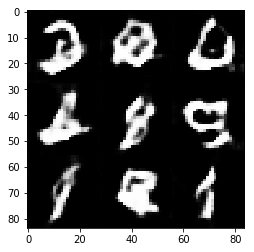

Step: 2210: Epoch 2/2... Discriminator Loss: 0.3452... Generator Loss: 6.8290
Step: 2220: Epoch 2/2... Discriminator Loss: 0.3389... Generator Loss: 6.5632
Step: 2230: Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 6.7663
Step: 2240: Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 6.0712
Step: 2250: Epoch 2/2... Discriminator Loss: 0.3381... Generator Loss: 7.3027
Step: 2260: Epoch 2/2... Discriminator Loss: 0.3324... Generator Loss: 7.1777
Step: 2270: Epoch 2/2... Discriminator Loss: 0.3330... Generator Loss: 5.6429
Step: 2280: Epoch 2/2... Discriminator Loss: 0.3371... Generator Loss: 5.0920
Step: 2290: Epoch 2/2... Discriminator Loss: 0.3354... Generator Loss: 6.3916
Step: 2300: Epoch 2/2... Discriminator Loss: 0.3453... Generator Loss: 6.2726


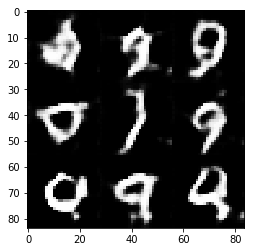

Step: 2310: Epoch 2/2... Discriminator Loss: 0.3332... Generator Loss: 7.7521
Step: 2320: Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 6.2592
Step: 2330: Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 5.9962
Step: 2340: Epoch 2/2... Discriminator Loss: 0.3553... Generator Loss: 4.4158
Step: 2350: Epoch 2/2... Discriminator Loss: 0.3424... Generator Loss: 5.8796
Step: 2360: Epoch 2/2... Discriminator Loss: 0.3341... Generator Loss: 6.9845
Step: 2370: Epoch 2/2... Discriminator Loss: 0.3294... Generator Loss: 6.2652
Step: 2380: Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 5.9938
Step: 2390: Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 6.4472
Step: 2400: Epoch 2/2... Discriminator Loss: 0.3269... Generator Loss: 7.9672


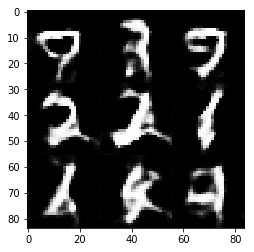

Step: 2410: Epoch 2/2... Discriminator Loss: 0.3328... Generator Loss: 8.5068
Step: 2420: Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 5.7514
Step: 2430: Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 6.7232
Step: 2440: Epoch 2/2... Discriminator Loss: 0.3271... Generator Loss: 7.1839
Step: 2450: Epoch 2/2... Discriminator Loss: 0.3625... Generator Loss: 5.1021
Step: 2460: Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 7.1375
Step: 2470: Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 6.2475
Step: 2480: Epoch 2/2... Discriminator Loss: 0.3345... Generator Loss: 5.5068
Step: 2490: Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 7.1731
Step: 2500: Epoch 2/2... Discriminator Loss: 0.3994... Generator Loss: 3.8007


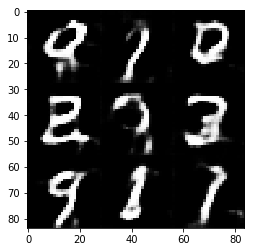

Step: 2510: Epoch 2/2... Discriminator Loss: 0.4589... Generator Loss: 3.4357
Step: 2520: Epoch 2/2... Discriminator Loss: 0.4066... Generator Loss: 4.2704
Step: 2530: Epoch 2/2... Discriminator Loss: 0.3393... Generator Loss: 6.3468
Step: 2540: Epoch 2/2... Discriminator Loss: 0.3485... Generator Loss: 4.9119
Step: 2550: Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 5.2517
Step: 2560: Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 6.6817
Step: 2570: Epoch 2/2... Discriminator Loss: 0.3383... Generator Loss: 7.0803
Step: 2580: Epoch 2/2... Discriminator Loss: 0.3607... Generator Loss: 5.6195
Step: 2590: Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 5.5323
Step: 2600: Epoch 2/2... Discriminator Loss: 0.3360... Generator Loss: 6.1378


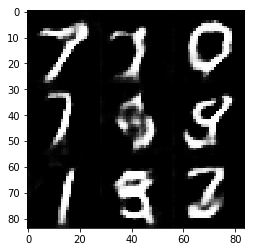

Step: 2610: Epoch 2/2... Discriminator Loss: 0.3279... Generator Loss: 7.3271
Step: 2620: Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 6.3682
Step: 2630: Epoch 2/2... Discriminator Loss: 0.3864... Generator Loss: 4.2129
Step: 2640: Epoch 2/2... Discriminator Loss: 0.3411... Generator Loss: 6.3734
Step: 2650: Epoch 2/2... Discriminator Loss: 0.3313... Generator Loss: 8.7873
Step: 2660: Epoch 2/2... Discriminator Loss: 0.3271... Generator Loss: 8.2197
Step: 2670: Epoch 2/2... Discriminator Loss: 0.3367... Generator Loss: 6.3950
Step: 2680: Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 5.8594
Step: 2690: Epoch 2/2... Discriminator Loss: 0.3316... Generator Loss: 6.0528
Step: 2700: Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 3.7421


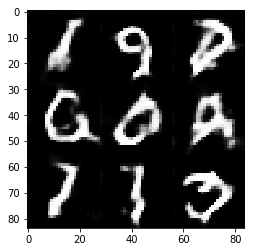

Step: 2710: Epoch 2/2... Discriminator Loss: 0.3360... Generator Loss: 5.9017
Step: 2720: Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 7.1839
Step: 2730: Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 7.1871
Step: 2740: Epoch 2/2... Discriminator Loss: 0.3310... Generator Loss: 6.8590
Step: 2750: Epoch 2/2... Discriminator Loss: 0.3426... Generator Loss: 7.4683
Step: 2760: Epoch 2/2... Discriminator Loss: 0.3597... Generator Loss: 5.1483
Step: 2770: Epoch 2/2... Discriminator Loss: 0.3368... Generator Loss: 6.2735
Step: 2780: Epoch 2/2... Discriminator Loss: 0.3449... Generator Loss: 6.2640
Step: 2790: Epoch 2/2... Discriminator Loss: 0.3683... Generator Loss: 4.3065
Step: 2800: Epoch 2/2... Discriminator Loss: 0.6266... Generator Loss: 2.3831


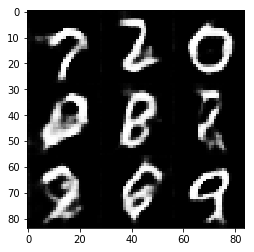

Step: 2810: Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 8.3255
Step: 2820: Epoch 2/2... Discriminator Loss: 0.3327... Generator Loss: 5.4690
Step: 2830: Epoch 2/2... Discriminator Loss: 0.3359... Generator Loss: 7.0425
Step: 2840: Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 7.1881
Step: 2850: Epoch 2/2... Discriminator Loss: 0.3744... Generator Loss: 5.3604
Step: 2860: Epoch 2/2... Discriminator Loss: 0.3363... Generator Loss: 6.2754
Step: 2870: Epoch 2/2... Discriminator Loss: 0.3575... Generator Loss: 4.7429
Step: 2880: Epoch 2/2... Discriminator Loss: 0.3340... Generator Loss: 7.5697
Step: 2890: Epoch 2/2... Discriminator Loss: 0.3421... Generator Loss: 5.0888
Step: 2900: Epoch 2/2... Discriminator Loss: 0.3282... Generator Loss: 7.2927


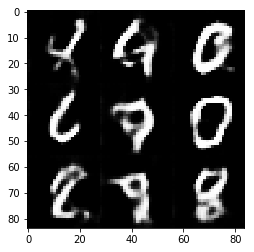

Step: 2910: Epoch 2/2... Discriminator Loss: 0.3311... Generator Loss: 5.8885
Step: 2920: Epoch 2/2... Discriminator Loss: 0.3457... Generator Loss: 5.3473
Step: 2930: Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 6.3154
Step: 2940: Epoch 2/2... Discriminator Loss: 0.3306... Generator Loss: 8.1430
Step: 2950: Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 3.3531
Step: 2960: Epoch 2/2... Discriminator Loss: 0.3418... Generator Loss: 5.8921
Step: 2970: Epoch 2/2... Discriminator Loss: 0.3272... Generator Loss: 8.3527
Step: 2980: Epoch 2/2... Discriminator Loss: 0.3638... Generator Loss: 6.1636
Step: 2990: Epoch 2/2... Discriminator Loss: 0.3335... Generator Loss: 5.6530
Step: 3000: Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 7.2098


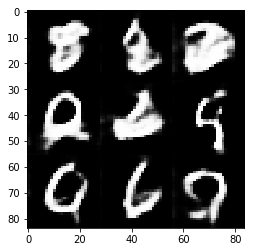

Step: 3010: Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 10.0474
Step: 3020: Epoch 2/2... Discriminator Loss: 0.3419... Generator Loss: 5.8121
Step: 3030: Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 5.2728
Step: 3040: Epoch 2/2... Discriminator Loss: 0.3344... Generator Loss: 5.7230
Step: 3050: Epoch 2/2... Discriminator Loss: 0.3550... Generator Loss: 4.3447
Step: 3060: Epoch 2/2... Discriminator Loss: 0.3411... Generator Loss: 5.1818
Step: 3070: Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 5.8804
Step: 3080: Epoch 2/2... Discriminator Loss: 0.3447... Generator Loss: 5.6632
Step: 3090: Epoch 2/2... Discriminator Loss: 0.3365... Generator Loss: 6.3869
Step: 3100: Epoch 2/2... Discriminator Loss: 0.3354... Generator Loss: 6.5633


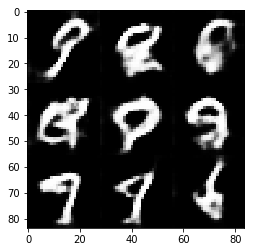

Step: 3110: Epoch 2/2... Discriminator Loss: 0.3281... Generator Loss: 8.0445
Step: 3120: Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 4.7896
Step: 3130: Epoch 2/2... Discriminator Loss: 0.3275... Generator Loss: 7.1539
Step: 3140: Epoch 2/2... Discriminator Loss: 0.3325... Generator Loss: 6.2483
Step: 3150: Epoch 2/2... Discriminator Loss: 0.3282... Generator Loss: 5.9827
Step: 3160: Epoch 2/2... Discriminator Loss: 0.3280... Generator Loss: 6.5273
Step: 3170: Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 2.0394
Step: 3180: Epoch 2/2... Discriminator Loss: 0.3309... Generator Loss: 5.9709
Step: 3190: Epoch 2/2... Discriminator Loss: 0.3349... Generator Loss: 6.2213
Step: 3200: Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 5.9559


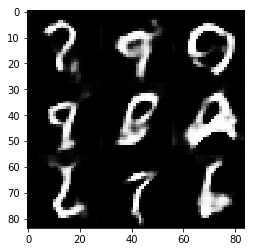

Step: 3210: Epoch 2/2... Discriminator Loss: 0.3422... Generator Loss: 6.3000
Step: 3220: Epoch 2/2... Discriminator Loss: 0.3282... Generator Loss: 7.1612
Step: 3230: Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 6.6354
Step: 3240: Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 6.4213
Step: 3250: Epoch 2/2... Discriminator Loss: 0.3283... Generator Loss: 6.9147
Step: 3260: Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 8.4697
Step: 3270: Epoch 2/2... Discriminator Loss: 0.4771... Generator Loss: 2.3473
Step: 3280: Epoch 2/2... Discriminator Loss: 0.3294... Generator Loss: 6.6173
Step: 3290: Epoch 2/2... Discriminator Loss: 0.3320... Generator Loss: 5.8047
Step: 3300: Epoch 2/2... Discriminator Loss: 0.4003... Generator Loss: 3.4089


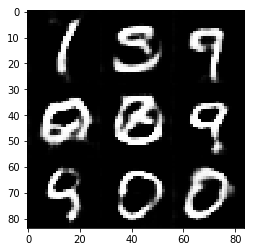

Step: 3310: Epoch 2/2... Discriminator Loss: 0.3289... Generator Loss: 7.3046
Step: 3320: Epoch 2/2... Discriminator Loss: 0.3286... Generator Loss: 7.4887
Step: 3330: Epoch 2/2... Discriminator Loss: 0.3319... Generator Loss: 6.9554
Step: 3340: Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 6.1134
Step: 3350: Epoch 2/2... Discriminator Loss: 0.3323... Generator Loss: 7.0909
Step: 3360: Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 5.9971
Step: 3370: Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 7.2660
Step: 3380: Epoch 2/2... Discriminator Loss: 0.3287... Generator Loss: 8.9970
Step: 3390: Epoch 2/2... Discriminator Loss: 0.3295... Generator Loss: 6.5243
Step: 3400: Epoch 2/2... Discriminator Loss: 0.3303... Generator Loss: 6.5829


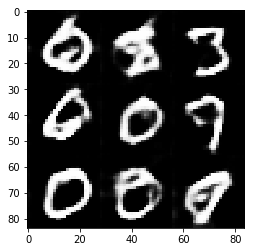

Step: 3410: Epoch 2/2... Discriminator Loss: 0.3492... Generator Loss: 5.6556
Step: 3420: Epoch 2/2... Discriminator Loss: 0.3287... Generator Loss: 6.3916
Step: 3430: Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 1.1081
Step: 3440: Epoch 2/2... Discriminator Loss: 0.3337... Generator Loss: 4.9007
Step: 3450: Epoch 2/2... Discriminator Loss: 0.3649... Generator Loss: 3.8788
Step: 3460: Epoch 2/2... Discriminator Loss: 0.3308... Generator Loss: 7.0487
Step: 3470: Epoch 2/2... Discriminator Loss: 0.3475... Generator Loss: 5.8270
Step: 3480: Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 6.7064
Step: 3490: Epoch 2/2... Discriminator Loss: 0.3482... Generator Loss: 5.5254
Step: 3500: Epoch 2/2... Discriminator Loss: 0.3356... Generator Loss: 7.8564


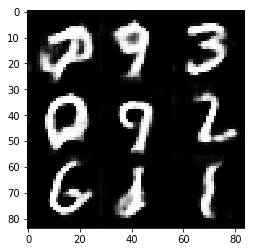

Step: 3510: Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 0.9457
Step: 3520: Epoch 2/2... Discriminator Loss: 0.3594... Generator Loss: 4.4740
Step: 3530: Epoch 2/2... Discriminator Loss: 0.3351... Generator Loss: 6.2696
Step: 3540: Epoch 2/2... Discriminator Loss: 0.3332... Generator Loss: 7.9143
Step: 3550: Epoch 2/2... Discriminator Loss: 0.3388... Generator Loss: 7.5337
Step: 3560: Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 4.7575
Step: 3570: Epoch 2/2... Discriminator Loss: 0.3370... Generator Loss: 6.4624
Step: 3580: Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 3.7563
Step: 3590: Epoch 2/2... Discriminator Loss: 0.3300... Generator Loss: 7.2170
Step: 3600: Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 5.6967


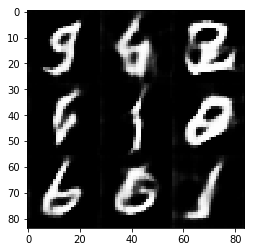

Step: 3610: Epoch 2/2... Discriminator Loss: 0.3336... Generator Loss: 8.5865
Step: 3620: Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 8.4427
Step: 3630: Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 6.6562
Step: 3640: Epoch 2/2... Discriminator Loss: 0.3325... Generator Loss: 6.7805
Step: 3650: Epoch 2/2... Discriminator Loss: 0.3278... Generator Loss: 9.7518
Step: 3660: Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 7.3292
Step: 3670: Epoch 2/2... Discriminator Loss: 0.3427... Generator Loss: 5.2630
Step: 3680: Epoch 2/2... Discriminator Loss: 0.3293... Generator Loss: 7.5103
Step: 3690: Epoch 2/2... Discriminator Loss: 0.3575... Generator Loss: 5.7746
Step: 3700: Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 8.0544


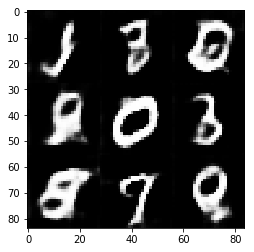

Step: 3710: Epoch 2/2... Discriminator Loss: 0.3403... Generator Loss: 6.2067
Step: 3720: Epoch 2/2... Discriminator Loss: 0.3323... Generator Loss: 5.7187
Step: 3730: Epoch 2/2... Discriminator Loss: 0.3353... Generator Loss: 4.5047
Step: 3740: Epoch 2/2... Discriminator Loss: 0.3662... Generator Loss: 5.4908
Step: 3750: Epoch 2/2... Discriminator Loss: 0.3286... Generator Loss: 8.7404
Finished the training


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting the training
Step: 10: Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 4.8986
Step: 20: Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 4.1296
Step: 30: Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 5.3392
Step: 40: Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 4.5906
Step: 50: Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 5.4484
Step: 60: Epoch 1/1... Discriminator Loss: 0.3818... Generator Loss: 5.3545
Step: 70: Epoch 1/1... Discriminator Loss: 0.3745... Generator Loss: 5.3506
Step: 80: Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.4199
Step: 90: Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 4.9339
Step: 100: Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 4.8190


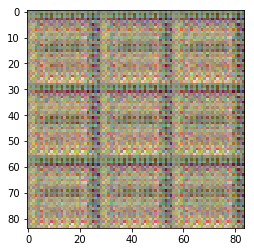

Step: 110: Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 5.1658
Step: 120: Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 4.8886
Step: 130: Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 5.8338
Step: 140: Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 3.3788
Step: 150: Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 6.3860
Step: 160: Epoch 1/1... Discriminator Loss: 0.3559... Generator Loss: 6.2629
Step: 170: Epoch 1/1... Discriminator Loss: 0.3498... Generator Loss: 5.9932
Step: 180: Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 5.5719
Step: 190: Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 6.4358
Step: 200: Epoch 1/1... Discriminator Loss: 0.3536... Generator Loss: 7.7857


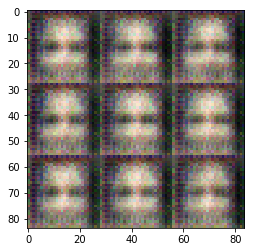

Step: 210: Epoch 1/1... Discriminator Loss: 0.3436... Generator Loss: 5.9783
Step: 220: Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 6.1319
Step: 230: Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 4.8229
Step: 240: Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 5.2616
Step: 250: Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 4.8091
Step: 260: Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 6.0903
Step: 270: Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 8.7074
Step: 280: Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.5572
Step: 290: Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 6.6769
Step: 300: Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 4.5375


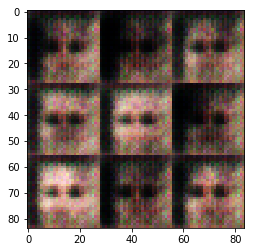

Step: 310: Epoch 1/1... Discriminator Loss: 0.3659... Generator Loss: 4.9063
Step: 320: Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.6663
Step: 330: Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 3.0333
Step: 340: Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.5788
Step: 350: Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.5524
Step: 360: Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 5.4858
Step: 370: Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 4.9049
Step: 380: Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.8349
Step: 390: Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 6.8140
Step: 400: Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 5.0179


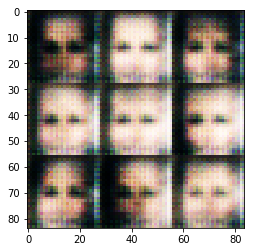

Step: 410: Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 4.6498
Step: 420: Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.8180
Step: 430: Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 4.8840
Step: 440: Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 4.7363
Step: 450: Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 4.4266
Step: 460: Epoch 1/1... Discriminator Loss: 0.3471... Generator Loss: 4.5113
Step: 470: Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 5.2719
Step: 480: Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 5.4022
Step: 490: Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 5.4285
Step: 500: Epoch 1/1... Discriminator Loss: 0.3654... Generator Loss: 4.4973


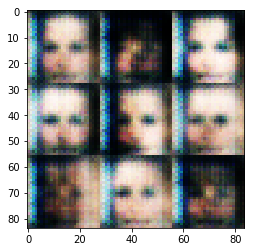

Step: 510: Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 4.2376
Step: 520: Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 5.1123
Step: 530: Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 5.0346
Step: 540: Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.0397
Step: 550: Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.6319
Step: 560: Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 3.0833
Step: 570: Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 4.4835
Step: 580: Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 5.6320
Step: 590: Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 5.1173
Step: 600: Epoch 1/1... Discriminator Loss: 0.3595... Generator Loss: 4.4526


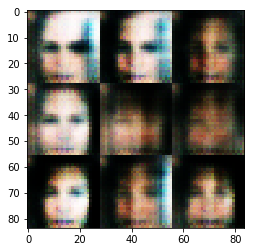

Step: 610: Epoch 1/1... Discriminator Loss: 0.3398... Generator Loss: 4.8291
Step: 620: Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 4.5907
Step: 630: Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 4.3968
Step: 640: Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 4.0983
Step: 650: Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 3.2504
Step: 660: Epoch 1/1... Discriminator Loss: 0.3476... Generator Loss: 3.7849
Step: 670: Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 4.6561
Step: 680: Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 4.5995
Step: 690: Epoch 1/1... Discriminator Loss: 0.5867... Generator Loss: 2.7994
Step: 700: Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 4.8816


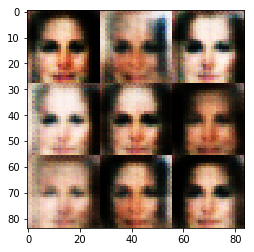

Step: 710: Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.8327
Step: 720: Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 4.5258
Step: 730: Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 6.0895
Step: 740: Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 3.5642
Step: 750: Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 3.6362
Step: 760: Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 3.9271
Step: 770: Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 3.7125
Step: 780: Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 4.6744
Step: 790: Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 4.0548
Step: 800: Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 3.0795


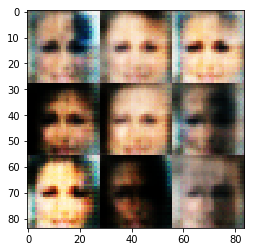

Step: 810: Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 4.1505
Step: 820: Epoch 1/1... Discriminator Loss: 0.3909... Generator Loss: 3.4982
Step: 830: Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.4987
Step: 840: Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 3.4644
Step: 850: Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 5.5663
Step: 860: Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 5.6441
Step: 870: Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 8.3572
Step: 880: Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 4.0843
Step: 890: Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 3.1977
Step: 900: Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 3.1502


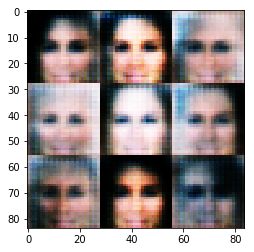

Step: 910: Epoch 1/1... Discriminator Loss: 0.3709... Generator Loss: 4.5245
Step: 920: Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 3.4497
Step: 930: Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 5.4399
Step: 940: Epoch 1/1... Discriminator Loss: 0.3664... Generator Loss: 4.4652
Step: 950: Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 3.9926
Step: 960: Epoch 1/1... Discriminator Loss: 0.3551... Generator Loss: 4.6941
Step: 970: Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 2.9841
Step: 980: Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 4.2881
Step: 990: Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 5.2982
Step: 1000: Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 4.9045


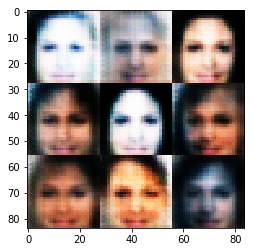

Step: 1010: Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 4.2303
Step: 1020: Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 3.4038
Step: 1030: Epoch 1/1... Discriminator Loss: 0.3483... Generator Loss: 5.7772
Step: 1040: Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 3.1707
Step: 1050: Epoch 1/1... Discriminator Loss: 0.3796... Generator Loss: 4.4277
Step: 1060: Epoch 1/1... Discriminator Loss: 0.3636... Generator Loss: 4.5749
Step: 1070: Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.9020
Step: 1080: Epoch 1/1... Discriminator Loss: 0.3972... Generator Loss: 3.7985
Step: 1090: Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 4.2387
Step: 1100: Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 4.9650


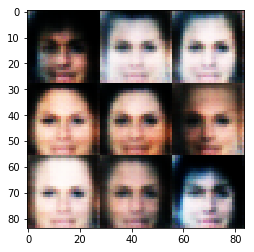

Step: 1110: Epoch 1/1... Discriminator Loss: 0.3566... Generator Loss: 4.5132
Step: 1120: Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 5.0828
Step: 1130: Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 5.5806
Step: 1140: Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 5.0601
Step: 1150: Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.5650
Step: 1160: Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 4.0003
Step: 1170: Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 4.7583
Step: 1180: Epoch 1/1... Discriminator Loss: 0.3859... Generator Loss: 3.7651
Step: 1190: Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 5.2651
Step: 1200: Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 4.3295


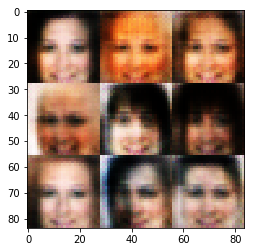

Step: 1210: Epoch 1/1... Discriminator Loss: 0.3981... Generator Loss: 4.2256
Step: 1220: Epoch 1/1... Discriminator Loss: 0.3739... Generator Loss: 4.5989
Step: 1230: Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 3.5167
Step: 1240: Epoch 1/1... Discriminator Loss: 0.3616... Generator Loss: 4.8055
Step: 1250: Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 5.0737
Step: 1260: Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 4.2843
Step: 1270: Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 4.9597
Step: 1280: Epoch 1/1... Discriminator Loss: 0.3888... Generator Loss: 3.6469
Step: 1290: Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 3.9561
Step: 1300: Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 3.4644


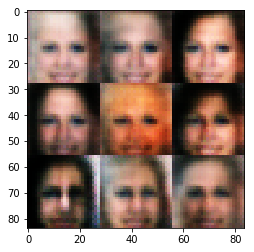

Step: 1310: Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 4.1298
Step: 1320: Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 4.9443
Step: 1330: Epoch 1/1... Discriminator Loss: 0.3699... Generator Loss: 4.4865
Step: 1340: Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 5.0468
Step: 1350: Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 3.5341
Step: 1360: Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 2.7456
Step: 1370: Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 4.5000
Step: 1380: Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 5.9415
Step: 1390: Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 5.3330
Step: 1400: Epoch 1/1... Discriminator Loss: 0.3615... Generator Loss: 5.0631


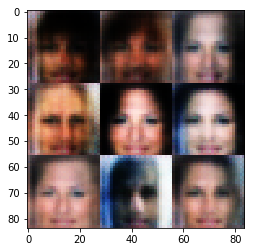

Step: 1410: Epoch 1/1... Discriminator Loss: 0.3540... Generator Loss: 5.7634
Step: 1420: Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 4.8935
Step: 1430: Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 4.7230
Step: 1440: Epoch 1/1... Discriminator Loss: 0.3413... Generator Loss: 5.2304
Step: 1450: Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 5.8671
Step: 1460: Epoch 1/1... Discriminator Loss: 0.3602... Generator Loss: 5.1431
Step: 1470: Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 5.3064
Step: 1480: Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 5.6287
Step: 1490: Epoch 1/1... Discriminator Loss: 0.3541... Generator Loss: 4.9385
Step: 1500: Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 4.8660


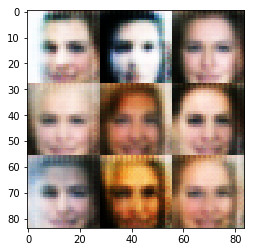

Step: 1510: Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.5808
Step: 1520: Epoch 1/1... Discriminator Loss: 0.3599... Generator Loss: 4.4680
Step: 1530: Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 5.1426
Step: 1540: Epoch 1/1... Discriminator Loss: 0.3852... Generator Loss: 5.1171
Step: 1550: Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 3.3593
Step: 1560: Epoch 1/1... Discriminator Loss: 0.3742... Generator Loss: 4.6966
Step: 1570: Epoch 1/1... Discriminator Loss: 0.3619... Generator Loss: 4.5582
Step: 1580: Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 6.4190
Step: 1590: Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 3.6055
Step: 1600: Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 4.2015


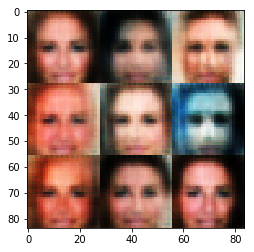

Step: 1610: Epoch 1/1... Discriminator Loss: 0.3724... Generator Loss: 5.0349
Step: 1620: Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 5.4886
Step: 1630: Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.5264
Step: 1640: Epoch 1/1... Discriminator Loss: 0.3650... Generator Loss: 4.1807
Step: 1650: Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 5.5336
Step: 1660: Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 4.7934
Step: 1670: Epoch 1/1... Discriminator Loss: 0.3978... Generator Loss: 4.1447
Step: 1680: Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 5.0733
Step: 1690: Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 4.5816
Step: 1700: Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 4.4991


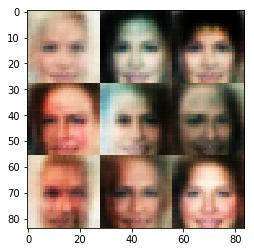

Step: 1710: Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 4.1741
Step: 1720: Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 3.9528
Step: 1730: Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 5.5579
Step: 1740: Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 6.5721
Step: 1750: Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 5.2006
Step: 1760: Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 5.0689
Step: 1770: Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 5.1094
Step: 1780: Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 2.4291
Step: 1790: Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 5.6381
Step: 1800: Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 5.8427


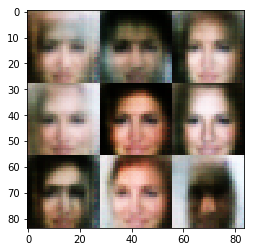

Step: 1810: Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 6.1088
Step: 1820: Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 5.2803
Step: 1830: Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 2.2095
Step: 1840: Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 4.8452
Step: 1850: Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 5.4347
Step: 1860: Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 2.1522
Step: 1870: Epoch 1/1... Discriminator Loss: 0.3646... Generator Loss: 5.6514
Step: 1880: Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 4.3209
Step: 1890: Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 4.8064
Step: 1900: Epoch 1/1... Discriminator Loss: 0.3544... Generator Loss: 4.6827


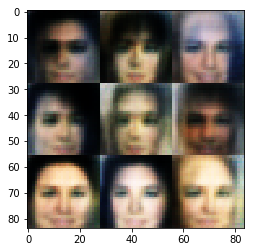

Step: 1910: Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 4.8880
Step: 1920: Epoch 1/1... Discriminator Loss: 0.4520... Generator Loss: 3.7808
Step: 1930: Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 6.0433
Step: 1940: Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 4.3733
Step: 1950: Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 3.9953
Step: 1960: Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 4.6168
Step: 1970: Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.5877
Step: 1980: Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 3.7810
Step: 1990: Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 5.1427
Step: 2000: Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 4.0809


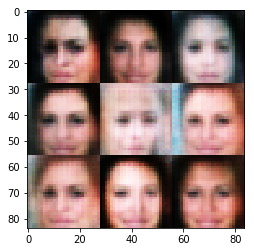

Step: 2010: Epoch 1/1... Discriminator Loss: 0.3715... Generator Loss: 4.2520
Step: 2020: Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 5.0914
Step: 2030: Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 4.9445
Step: 2040: Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 5.4440
Step: 2050: Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 4.7700
Step: 2060: Epoch 1/1... Discriminator Loss: 0.3433... Generator Loss: 5.7944
Step: 2070: Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 5.0327
Step: 2080: Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 5.1168
Step: 2090: Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 5.1292
Step: 2100: Epoch 1/1... Discriminator Loss: 0.3677... Generator Loss: 4.7062


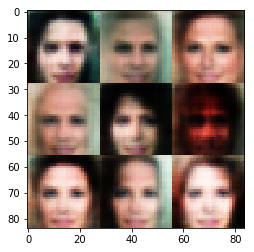

Step: 2110: Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 4.8958
Step: 2120: Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 4.8514
Step: 2130: Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 5.3513
Step: 2140: Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 4.6145
Step: 2150: Epoch 1/1... Discriminator Loss: 0.3762... Generator Loss: 3.5746
Step: 2160: Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 4.6961
Step: 2170: Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 4.4833
Step: 2180: Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 6.3111
Step: 2190: Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 5.7525
Step: 2200: Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 6.0174


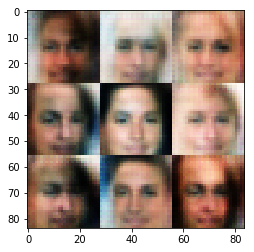

Step: 2210: Epoch 1/1... Discriminator Loss: 0.3771... Generator Loss: 4.8552
Step: 2220: Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 5.7282
Step: 2230: Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 5.6969
Step: 2240: Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 5.1575
Step: 2250: Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 5.3047
Step: 2260: Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 3.0798
Step: 2270: Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 3.0975
Step: 2280: Epoch 1/1... Discriminator Loss: 0.3461... Generator Loss: 5.3635
Step: 2290: Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 5.3773
Step: 2300: Epoch 1/1... Discriminator Loss: 0.3597... Generator Loss: 4.5995


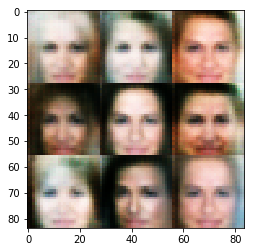

Step: 2310: Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 5.9220
Step: 2320: Epoch 1/1... Discriminator Loss: 0.3538... Generator Loss: 5.7734
Step: 2330: Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 4.8751
Step: 2340: Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 4.9833
Step: 2350: Epoch 1/1... Discriminator Loss: 0.3658... Generator Loss: 3.7369
Step: 2360: Epoch 1/1... Discriminator Loss: 0.3652... Generator Loss: 4.4763
Step: 2370: Epoch 1/1... Discriminator Loss: 0.3479... Generator Loss: 4.9474
Step: 2380: Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 2.7236
Step: 2390: Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 3.7444
Step: 2400: Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 5.1914


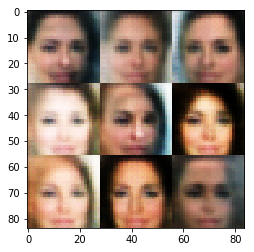

Step: 2410: Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 5.9989
Step: 2420: Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 4.7347
Step: 2430: Epoch 1/1... Discriminator Loss: 0.3469... Generator Loss: 5.1239
Step: 2440: Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 4.6824
Step: 2450: Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 4.9583
Step: 2460: Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 5.7639
Step: 2470: Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 5.8448
Step: 2480: Epoch 1/1... Discriminator Loss: 0.3448... Generator Loss: 5.5121
Step: 2490: Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 4.9487
Step: 2500: Epoch 1/1... Discriminator Loss: 0.3393... Generator Loss: 5.1140


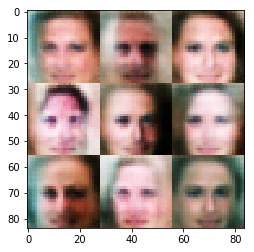

Step: 2510: Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 5.6295
Step: 2520: Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 5.0952
Step: 2530: Epoch 1/1... Discriminator Loss: 0.3429... Generator Loss: 5.1954
Step: 2540: Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 6.7370
Step: 2550: Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 6.4855
Step: 2560: Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 4.5297
Step: 2570: Epoch 1/1... Discriminator Loss: 0.3705... Generator Loss: 4.7104
Step: 2580: Epoch 1/1... Discriminator Loss: 0.3735... Generator Loss: 3.7849
Step: 2590: Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 5.5035
Step: 2600: Epoch 1/1... Discriminator Loss: 0.3407... Generator Loss: 5.5820


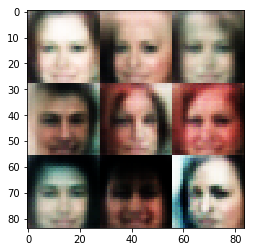

Step: 2610: Epoch 1/1... Discriminator Loss: 0.3400... Generator Loss: 5.5232
Step: 2620: Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.9319
Step: 2630: Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 6.0833
Step: 2640: Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 5.5339
Step: 2650: Epoch 1/1... Discriminator Loss: 0.3808... Generator Loss: 3.7014
Step: 2660: Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 4.8404
Step: 2670: Epoch 1/1... Discriminator Loss: 0.3380... Generator Loss: 5.7534
Step: 2680: Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 4.1942
Step: 2690: Epoch 1/1... Discriminator Loss: 1.9716... Generator Loss: 1.3380
Step: 2700: Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.8056


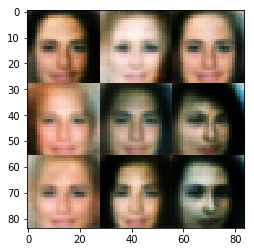

Step: 2710: Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 4.8642
Step: 2720: Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 2.8842
Step: 2730: Epoch 1/1... Discriminator Loss: 0.6618... Generator Loss: 2.2086
Step: 2740: Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 4.1381
Step: 2750: Epoch 1/1... Discriminator Loss: 0.3434... Generator Loss: 4.8137
Step: 2760: Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.6719
Step: 2770: Epoch 1/1... Discriminator Loss: 0.3394... Generator Loss: 5.1070
Step: 2780: Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 4.6556
Step: 2790: Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 4.5700
Step: 2800: Epoch 1/1... Discriminator Loss: 0.3499... Generator Loss: 4.7735


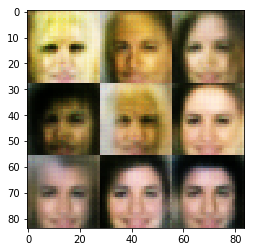

Step: 2810: Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 5.8331
Step: 2820: Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 4.7368
Step: 2830: Epoch 1/1... Discriminator Loss: 0.3596... Generator Loss: 4.6021
Step: 2840: Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 5.1275
Step: 2850: Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 4.7310
Step: 2860: Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 5.3063
Step: 2870: Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 5.1404
Step: 2880: Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.6768
Step: 2890: Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 5.2646
Step: 2900: Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 5.9545


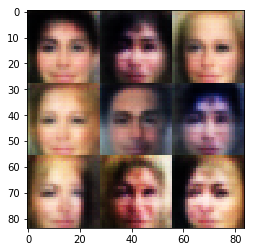

Step: 2910: Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 5.9603
Step: 2920: Epoch 1/1... Discriminator Loss: 0.3381... Generator Loss: 5.5009
Step: 2930: Epoch 1/1... Discriminator Loss: 0.3521... Generator Loss: 4.5465
Step: 2940: Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 6.5049
Step: 2950: Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 6.0142
Step: 2960: Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 3.9680
Step: 2970: Epoch 1/1... Discriminator Loss: 0.3353... Generator Loss: 4.7856
Step: 2980: Epoch 1/1... Discriminator Loss: 0.3375... Generator Loss: 5.1774
Step: 2990: Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 4.7754
Step: 3000: Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 4.5546


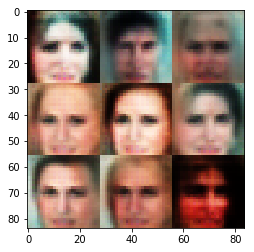

Step: 3010: Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 4.4334
Step: 3020: Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 5.4479
Step: 3030: Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 3.7455
Step: 3040: Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 6.1234
Step: 3050: Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 3.6251
Step: 3060: Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 4.8217
Step: 3070: Epoch 1/1... Discriminator Loss: 0.3721... Generator Loss: 3.9998
Step: 3080: Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 5.5605
Step: 3090: Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 4.4164
Step: 3100: Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 4.9691


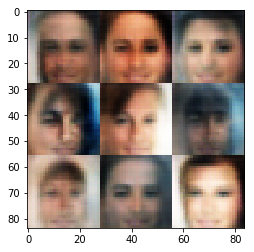

Step: 3110: Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 4.5081
Step: 3120: Epoch 1/1... Discriminator Loss: 0.3569... Generator Loss: 4.0989
Step: 3130: Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 5.4386
Step: 3140: Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 5.6077
Step: 3150: Epoch 1/1... Discriminator Loss: 0.3514... Generator Loss: 5.1193
Step: 3160: Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 5.0202
Step: 3170: Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 3.9289
Step: 3180: Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 5.8175
Step: 3190: Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 5.0834
Step: 3200: Epoch 1/1... Discriminator Loss: 0.3550... Generator Loss: 5.0164


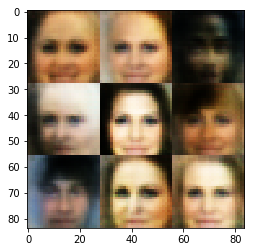

Step: 3210: Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 4.1653
Step: 3220: Epoch 1/1... Discriminator Loss: 0.3484... Generator Loss: 6.0852
Step: 3230: Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 5.8418
Step: 3240: Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 4.0157
Step: 3250: Epoch 1/1... Discriminator Loss: 0.3582... Generator Loss: 5.4467
Step: 3260: Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 5.4189
Step: 3270: Epoch 1/1... Discriminator Loss: 0.3504... Generator Loss: 4.8494
Step: 3280: Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 6.7874
Step: 3290: Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 3.7272
Step: 3300: Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 4.8221


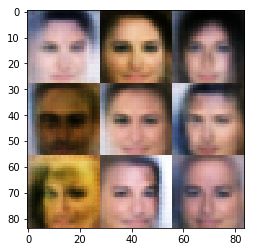

Step: 3310: Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 5.2075
Step: 3320: Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 4.7691
Step: 3330: Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 4.6245
Step: 3340: Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 6.9244
Step: 3350: Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 4.5925
Step: 3360: Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 5.4645
Step: 3370: Epoch 1/1... Discriminator Loss: 0.3387... Generator Loss: 4.4126
Step: 3380: Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 5.2007
Step: 3390: Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 5.5820
Step: 3400: Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 5.3537


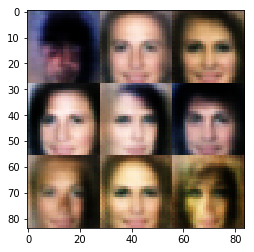

Step: 3410: Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 4.4733
Step: 3420: Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 4.8409
Step: 3430: Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 5.4523
Step: 3440: Epoch 1/1... Discriminator Loss: 0.3339... Generator Loss: 5.0381
Step: 3450: Epoch 1/1... Discriminator Loss: 0.3374... Generator Loss: 6.8952
Step: 3460: Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 2.8723
Step: 3470: Epoch 1/1... Discriminator Loss: 0.3570... Generator Loss: 6.1431
Step: 3480: Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 4.9626
Step: 3490: Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 6.5349
Step: 3500: Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 5.8590


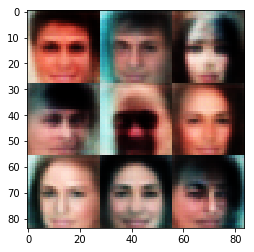

Step: 3510: Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 8.7564
Step: 3520: Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 2.7089
Step: 3530: Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 2.9131
Step: 3540: Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.9958
Step: 3550: Epoch 1/1... Discriminator Loss: 0.5101... Generator Loss: 2.4370
Step: 3560: Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 5.8987
Step: 3570: Epoch 1/1... Discriminator Loss: 0.4417... Generator Loss: 4.0298
Step: 3580: Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 3.4622
Step: 3590: Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 5.3629
Step: 3600: Epoch 1/1... Discriminator Loss: 0.3385... Generator Loss: 5.8709


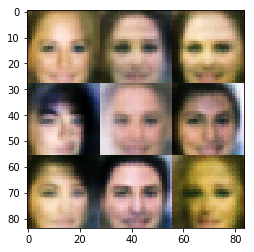

Step: 3610: Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 4.9583
Step: 3620: Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 3.9532
Step: 3630: Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 4.1857
Step: 3640: Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 5.4559
Step: 3650: Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 5.1172
Step: 3660: Epoch 1/1... Discriminator Loss: 0.3686... Generator Loss: 5.0845
Step: 3670: Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 5.5599
Step: 3680: Epoch 1/1... Discriminator Loss: 0.3358... Generator Loss: 4.8448
Step: 3690: Epoch 1/1... Discriminator Loss: 0.3452... Generator Loss: 5.3595
Step: 3700: Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 4.3644


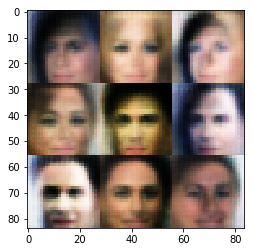

Step: 3710: Epoch 1/1... Discriminator Loss: 0.3485... Generator Loss: 5.9240
Step: 3720: Epoch 1/1... Discriminator Loss: 0.3326... Generator Loss: 7.6796
Step: 3730: Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 4.7694
Step: 3740: Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 5.1690
Step: 3750: Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 2.9240
Step: 3760: Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 5.1229
Step: 3770: Epoch 1/1... Discriminator Loss: 0.3410... Generator Loss: 6.4923
Step: 3780: Epoch 1/1... Discriminator Loss: 0.3372... Generator Loss: 5.9041
Step: 3790: Epoch 1/1... Discriminator Loss: 0.3365... Generator Loss: 5.4162
Step: 3800: Epoch 1/1... Discriminator Loss: 0.3347... Generator Loss: 6.6801


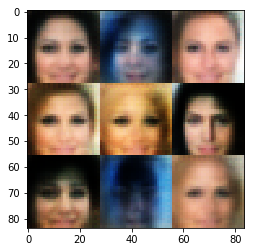

Step: 3810: Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 5.5991
Step: 3820: Epoch 1/1... Discriminator Loss: 0.3421... Generator Loss: 5.0180
Step: 3830: Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 6.0327
Step: 3840: Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 4.5740
Step: 3850: Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 3.0051
Step: 3860: Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 6.1427
Step: 3870: Epoch 1/1... Discriminator Loss: 0.3308... Generator Loss: 6.7061
Step: 3880: Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 6.0558
Step: 3890: Epoch 1/1... Discriminator Loss: 0.3409... Generator Loss: 5.2624
Step: 3900: Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 5.4147


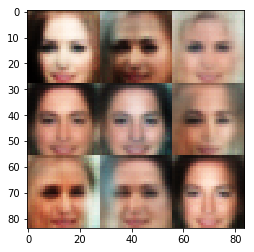

Step: 3910: Epoch 1/1... Discriminator Loss: 0.3342... Generator Loss: 6.3122
Step: 3920: Epoch 1/1... Discriminator Loss: 0.3397... Generator Loss: 6.1774
Step: 3930: Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 2.8713
Step: 3940: Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 5.5422
Step: 3950: Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 6.2907
Step: 3960: Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 4.4876
Step: 3970: Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 5.9502
Step: 3980: Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 6.2674
Step: 3990: Epoch 1/1... Discriminator Loss: 0.3669... Generator Loss: 5.5633
Step: 4000: Epoch 1/1... Discriminator Loss: 0.3427... Generator Loss: 5.4696


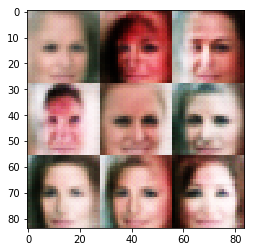

Step: 4010: Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 4.6410
Step: 4020: Epoch 1/1... Discriminator Loss: 0.3415... Generator Loss: 7.3832
Step: 4030: Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 5.3558
Step: 4040: Epoch 1/1... Discriminator Loss: 0.3371... Generator Loss: 5.8705
Step: 4050: Epoch 1/1... Discriminator Loss: 0.3321... Generator Loss: 6.4861
Step: 4060: Epoch 1/1... Discriminator Loss: 0.3330... Generator Loss: 7.1297
Step: 4070: Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 6.4540
Step: 4080: Epoch 1/1... Discriminator Loss: 0.3344... Generator Loss: 5.2809
Step: 4090: Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.2748
Step: 4100: Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 5.8061


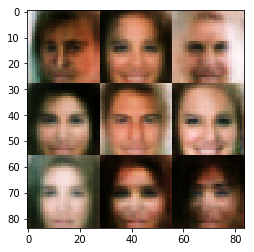

Step: 4110: Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 6.3124
Step: 4120: Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 5.8394
Step: 4130: Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 4.7446
Step: 4140: Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 6.2209
Step: 4150: Epoch 1/1... Discriminator Loss: 0.3382... Generator Loss: 5.8304
Step: 4160: Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 6.9339
Step: 4170: Epoch 1/1... Discriminator Loss: 0.3414... Generator Loss: 5.9932
Step: 4180: Epoch 1/1... Discriminator Loss: 0.3395... Generator Loss: 5.5132
Step: 4190: Epoch 1/1... Discriminator Loss: 0.3388... Generator Loss: 5.7195
Step: 4200: Epoch 1/1... Discriminator Loss: 0.3354... Generator Loss: 6.2445


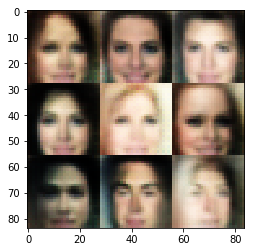

Step: 4210: Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 7.3903
Step: 4220: Epoch 1/1... Discriminator Loss: 0.3391... Generator Loss: 5.4140
Step: 4230: Epoch 1/1... Discriminator Loss: 0.3373... Generator Loss: 5.5924
Step: 4240: Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 5.0455
Step: 4250: Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 6.9038
Step: 4260: Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 5.9171
Step: 4270: Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 4.9423
Step: 4280: Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 6.6900
Step: 4290: Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.9095
Step: 4300: Epoch 1/1... Discriminator Loss: 0.3406... Generator Loss: 5.8786


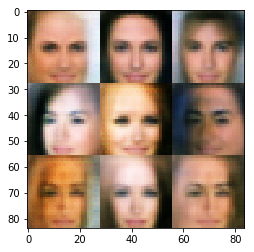

Step: 4310: Epoch 1/1... Discriminator Loss: 0.3350... Generator Loss: 7.3290
Step: 4320: Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 6.2787
Step: 4330: Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 5.9777
Step: 4340: Epoch 1/1... Discriminator Loss: 0.3423... Generator Loss: 7.0166
Step: 4350: Epoch 1/1... Discriminator Loss: 0.3408... Generator Loss: 6.3983
Step: 4360: Epoch 1/1... Discriminator Loss: 0.3369... Generator Loss: 5.8969
Step: 4370: Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 7.3570
Step: 4380: Epoch 1/1... Discriminator Loss: 0.3327... Generator Loss: 6.6980
Step: 4390: Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 6.1447
Step: 4400: Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 5.2820


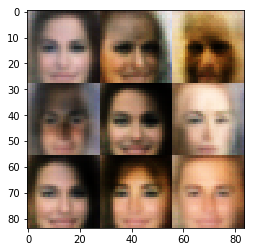

Step: 4410: Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 6.4801
Step: 4420: Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 5.2968
Step: 4430: Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 4.7374
Step: 4440: Epoch 1/1... Discriminator Loss: 0.3309... Generator Loss: 6.8814
Step: 4450: Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 4.5329
Step: 4460: Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 5.9492
Step: 4470: Epoch 1/1... Discriminator Loss: 0.3581... Generator Loss: 6.0248
Step: 4480: Epoch 1/1... Discriminator Loss: 0.3996... Generator Loss: 6.4912
Step: 4490: Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 2.7709
Step: 4500: Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 5.4959


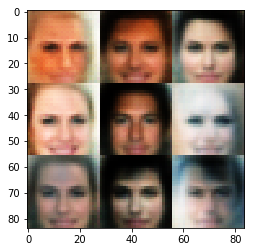

Step: 4510: Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.7298
Step: 4520: Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 4.1486
Step: 4530: Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 5.0459
Step: 4540: Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 4.3649
Step: 4550: Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 4.5758
Step: 4560: Epoch 1/1... Discriminator Loss: 0.3635... Generator Loss: 3.2263
Step: 4570: Epoch 1/1... Discriminator Loss: 0.5710... Generator Loss: 2.7463
Step: 4580: Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 3.6011
Step: 4590: Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 3.5623
Step: 4600: Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 4.2242


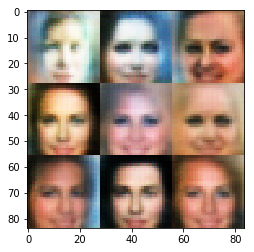

Step: 4610: Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 6.5689
Step: 4620: Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 5.8535
Step: 4630: Epoch 1/1... Discriminator Loss: 0.3530... Generator Loss: 4.8703
Step: 4640: Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 5.8529
Step: 4650: Epoch 1/1... Discriminator Loss: 0.3515... Generator Loss: 5.7203
Step: 4660: Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 5.5470
Step: 4670: Epoch 1/1... Discriminator Loss: 0.3784... Generator Loss: 5.0189
Step: 4680: Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 5.1859


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.